# Owkin FL Data Challenge - Train Model
Multiple Myeloma (MM) is a type of bone marrow cancer. Treatment for MM involves  
combinations of drugs over multiple cycles. There is huge heterogeneity in treatment  
response with some individuals not responding to treatment and some patients responding  
well to treatment for some time before a relapse. A better characterization of patients who  
relapse early can influence the treatment options and combinations

## Import libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

from pathlib import Path

In [2]:
# autoreload changes from local files
%load_ext autoreload
%autoreload 2

# pandas show full output
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 200)

# add module path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from src import config
from src import preprocess
from src import model
from src import visual
from src import gene

## Train model

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

Load input data

In [5]:
df_model = preprocess.create_model_input_data()
df_model.head()

,D_Age,D_Gender,D_ISS,CYTO_predicted_feature_01,CYTO_predicted_feature_02,CYTO_predicted_feature_03,CYTO_predicted_feature_05,CYTO_predicted_feature_06,CYTO_predicted_feature_08,CYTO_predicted_feature_10,CYTO_predicted_feature_12,CYTO_predicted_feature_13,CYTO_predicted_feature_14,CYTO_predicted_feature_15,CYTO_predicted_feature_16,CYTO_predicted_feature_17,CYTO_predicted_feature_18,HR_FLAG,Entrez_1,Entrez_2,Entrez_3,Entrez_9,Entrez_10,Entrez_13,Entrez_14,Entrez_15,Entrez_16,Entrez_18,Entrez_19,Entrez_20,Entrez_21,Entrez_22,Entrez_23,Entrez_24,Entrez_25,Entrez_26,Entrez_27,Entrez_28,Entrez_29,Entrez_30,Entrez_32,Entrez_33,Entrez_34,Entrez_35,Entrez_36,Entrez_37,Entrez_38,Entrez_39,Entrez_40,Entrez_41,Entrez_43,Entrez_47,Entrez_48,Entrez_49,Entrez_50,Entrez_51,Entrez_52,Entrez_53,Entrez_54,Entrez_55,Entrez_56,Entrez_58,Entrez_59,Entrez_60,Entrez_70,Entrez_71,Entrez_72,Entrez_81,Entrez_86,Entrez_87,Entrez_88,Entrez_89,Entrez_90,Entrez_91,Entrez_92,Entrez_93,Entrez_94,Entrez_95,Entrez_97,Entrez_98,Entrez_100,Entrez_101,Entrez_102,Entrez_103,Entrez_104,Entrez_105,Entrez_107,Entrez_108,Entrez_109,Entrez_111,Entrez_112,Entrez_113,Entrez_114,Entrez_115,Entrez_116,Entrez_117,Entrez_118,Entrez_119,Entrez_120,Entrez_123,...,Entrez_252953,Entrez_252955,Entrez_2576,Entrez_26240,Entrez_26267,Entrez_2657,Entrez_26628,Entrez_27183,Entrez_27328,Entrez_284194,Entrez_284366,Entrez_2844,Entrez_286128,Entrez_29940,Entrez_29994,Entrez_3117,Entrez_3222,Entrez_3316,Entrez_344,Entrez_3690,Entrez_3742,Entrez_3753,Entrez_378108,Entrez_378948,Entrez_387104,Entrez_388389,Entrez_3963,Entrez_3987,Entrez_401428,Entrez_414245,Entrez_4253,Entrez_440574,Entrez_440895,Entrez_4701,Entrez_4714,Entrez_50858,Entrez_5098,Entrez_51124,Entrez_51263,Entrez_51326,Entrez_51643,Entrez_51735,Entrez_51750,Entrez_5296,Entrez_53916,Entrez_54949,Entrez_552900,Entrez_55308,Entrez_5683,Entrez_572558,Entrez_57335,Entrez_57497,Entrez_57501,Entrez_582,Entrez_58496,Entrez_5940,Entrez_60677,Entrez_6139,Entrez_641367,Entrez_641517,Entrez_642778,Entrez_645166,Entrez_64788,Entrez_65082,Entrez_653067,Entrez_65988,Entrez_6606,Entrez_6844,Entrez_727856,Entrez_728047,Entrez_728411,Entrez_728734,Entrez_731275,Entrez_7730,Entrez_79086,Entrez_79741,Entrez_80006,Entrez_805,Entrez_80829,Entrez_8190,Entrez_8293,Entrez_8302,Entrez_83864,Entrez_83986,Entrez_84220,Entrez_84342,Entrez_84619,Entrez_84672,Entrez_84673,Entrez_8490,Entrez_84976,Entrez_8509,Entrez_86614,Entrez_8778,Entrez_8926,Entrez_9570,Entrez_9692,Entrez_9720,Entrez_9768,Entrez_9797
0,54,Female,1.0,0,0,1,0,1,0,0.0,0,0,0,0,0,0,0,0,1.91152,1.052220,0.000000,1.32682,0.017741,0.0,21.8491,0.132461,37.7567,0.530183,0.080738,0.141804,0.961001,2.00144,6.06448,0.001373,3.42017,1.988480,1.88296,0.0,0.472959,8.90261,2.161210,0.0,17.3597,2.48858,3.45787,89.2955,13.1171,2.38812,0.000000,0.192276,0.019469,10.16190,2.40884,0.000000,31.7228,4.40584,27.6856,8.08636,1.76793,0.171033,0.023643,0.110831,0.050319,325.280,0.0,172.952,0.022757,32.3042,9.79501,0.342947,0.00668,0.003535,4.07282,1.69488,1.81417,1.086230,0.219925,4.46476,1.436740,11.26340,4.20791,0.240429,11.3392,39.3073,0.500683,0.022496,0.064629,0.614031,1.61732,1.045000,0.459284,7.21686,0.0,0.650564,0.062796,0.021724,17.7313,0.995783,10.64310,6.96452,...,0.0,0.000000,0.632119,0.510625,1.934862,0.021062,0.080846,7.615600,0.019016,0.027905,0.0,1.296815,1.009790,0.193543,4.027437,0.268412,0.000000,0.000000,0.000000,0.047374,0.036188,0.002612,1.018918,0.0,0.085083,0.071193,0.012198,2.297667,1.877080,0.672752,10.89470,20.610440,0.008651,14.19960,21.412693,0.0,0.866740,11.420350,2.17459,0.952630,32.936036,0.756935,0.779276,1.851010,2.490355,7.192255,21.608020,4.170538,26.457540,0.013433,0.669656,0.0,0.028623,1.107405,0.467547,0.0,0.013271,184.478070,0.010782,0.0,6.364438,1.919350,5.961430,2.138259,0.013065,0.655035,7.387795,15.30910,0.049598,0.228129,2.996635,0.108341,1.339705,0.650329,16.540905,0.456176,2.247445,73.67665,3.667881,0.000000,3.441502,0.004281,0.0,1.470760,1.302864,2.273370,3.361188,0.

In [6]:
count_missing_values = df_model.isnull().sum()
count_missing_values[count_missing_values > 0]

D_ISS                         15
CYTO_predicted_feature_10    221
dtype: int64

Split in training and testing

In [7]:
y = df_model[config.TARGET]
X = df_model.copy().drop(columns=config.TARGET)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=config.RANDOM_STATE)

Train models/pipelines and save them to disk.

In [9]:
model_names = ['RF', 'XGB']
select_k = 1500
pipelines = [model.get_pipeline_rf(X_train, select_k=select_k), model.get_pipeline_xgb(X_train, select_k=select_k)]
param_grids = [model.get_param_grid_rf(prefix='clf'), model.get_param_grid_xgb(prefix='clf')]

model.train_multiple_models(X_train, y_train, X_test, y_test, model_names, pipelines, param_grids)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Model saved to: C:\projects\side_projects\owkin_fl_data_challenge\models\model_RF_2022-11-11.joblib
RF - average_precision test data: 0.5303713709389385 

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Model saved to: C:\projects\side_projects\owkin_fl_data_challenge\models\model_XGB_2022-11-11.joblib
XGB - average_precision test data: 0.4596776254275295 



## Evaluate model performance

Specify model data, load respective model and create model evaluation report

In [10]:
model_date = '2022-11-11'

In [11]:
model_name = 'RF'
clf = model.load_model(model_date, model_name)
clf


Load model from: C:\projects\side_projects\owkin_fl_data_challenge\models\model_RF_2022-11-11.joblib


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('ohe_nominal',
                                                                               OneHotEncoder(sparse=False),
                                                                               ['D_Gender']),
                                                                              ('impute_ordinal',
                                                                               SimpleImputer(strategy='most_frequent'),
                                                                               ['D_Age',
                                                                                'D_ISS']),
                                                                              ('impute_continuous',
                                                                               SimpleImputer(strategy='median'),
                                                                               ['CYTO_predicted_feature_01',
                                                                                'CYTO_predicted_feature_02',
                                                                                'CYTO_pre...
                   param_distributions={'clf__bootstrap': [True, False],
                                        'clf__class_weight': ['balanced',
                                                              'balanced_subsample',
                                                              None],
                                        'clf__criterion': ['gini', 'entropy'],
                                        'clf__max_depth': range(5, 250, 5),
                                        'clf__max_features': ['sqrt', 'log2',
                                                              None],
                                        'clf__min_samples_leaf': range(2, 30, 2),
                                        'clf__min_samples_split': range(2, 30, 2),
                                        'clf__n_estimators': range(100, 2500, 100)},
                   scoring='average_precision', verbose=1)

In [12]:
df_feature_importance = model.get_feature_importance_df(clf, list(X_test.columns))
df_feature_importance.head()

,feature,importance
0,D_Age,0.008315
1,Entrez_692205,0.007736
2,Entrez_284996,0.007307
3,Entrez_10216,0.006353
4,Entrez_85415,0.006292


In [17]:
df_feature_importance.query('feature == "Entrez_26147"')

,feature,importance
42,Entrez_26147,0.003078


In [18]:
df_feature_importance.query('feature == "Entrez_7468"')

,feature,importance


In [19]:
df_feature_importance.query('feature == "D_ISS"')

,feature,importance
83,D_ISS,0.002369


In [13]:
entrez_features = [c.split('_')[1] for c in df_feature_importance['feature'] if 'Entrez' in c]
# dict_genes = gene.get_gene_descriptions('d.knoors@gmail.com', entrez_features)

In [28]:
df_entrez = pd.read_csv(config.PATH_DATA / 'entrez_id_ncbi_description.txt', delimiter = "\t")
df_entrez.head()

,tax_id,Org_name,GeneID,CurrentID,Status,Symbol,Aliases,description,other_designations,map_location,chromosome,genomic_nucleotide_accession.version,start_position_on_the_genomic_accession,end_position_on_the_genomic_accession,orientation,exon_count,OMIM,Unnamed: 17
0,9606,Homo sapiens,12,0,live,SERPINA3,"AACT, ACT, GIG24, GIG25",serpin family A member 3,alpha-1-antichymotrypsin|cell growth-inhibitin...,14q32.13,14,NC_000014.9,94612391.0,94624053.0,plus,7.0,107280.0,NaN
1,9606,Homo sapiens,97,0,live,ACYP1,ACYPE,acylphosphatase 1,"acylphosphatase-1|acylphosphatase 1, erythrocy...",14q24.3,14,NC_000014.9,75053243.0,75069490.0,minus,5.0,600875.0,NaN
2,9606,Homo sapiens,125,0,live,ADH1B,"ADH2, HEL-S-117","alcohol dehydrogenase 1B (class I), beta polyp...",all-trans-retinol dehydrogenase [NAD(+)] ADH1B...,4q23,4,NC_000004.12,99304971.0,99321401.0,minus,10.0,103720.0,NaN
3,9606,Homo sapiens,158,0,live,ADSL,"AMPS, ASASE, ASL",adenylosuccinate lyase,adenylosuccinate lyase|adenylosuccinase,22q13.1,22,NC_000022.11,40346500.0,40387527.0,plus,14.0,608222.0,NaN
4,9606,Homo sapiens,186,0,live,AGTR2,"AT2, ATGR2, MRX88",angiotensin II receptor type 2,type-2 angiotensin II receptor|AT2 receptor|an...,Xq23,X,NC_000023.11,116170744.0,116174974.0,plus,3.0,300034.0,NaN


In [37]:
df_feature_importance['GeneID'] = df_feature_importance.feature.apply(lambda x: int(x.split('_')[1]) if 'Entrez' in x else np.nan)
df_fi_extended = df_feature_importance.merge(df_entrez[['GeneID', 'Symbol', 'description']], on='GeneID', how='left')
df_fi_extended[:20]

,feature,importance,GeneID,Symbol,description
0,D_Age,0.008315,NaN,NaN,NaN
1,Entrez_692205,0.007736,692205.0,SNORD89,"small nucleolar RNA, C/D box 89"
2,Entrez_284996,0.007307,284996.0,RNF149,ring finger protein 149
3,Entrez_10216,0.006353,10216.0,PRG4,proteoglycan 4
4,Entrez_85415,0.006292,85415.0,RHPN2,rhophilin Rho GTPase binding protein 2
5,Entrez_2316,0.005046,2316.0,FLNA,filamin A
6,Entrez_129790,0.005036,129790.0,C7orf13,chromosome 7 open reading frame 13
7,Entrez_126731,0.004639,126731.0,CCSAP,"centriole, cilia and spindle associated protein"
8,Entrez_3738,0.004608,3738.0,KCNA3,potassium voltage-gated channel subfamily A me...
9,Entrez_3664,0.004356,3664.0,IRF6,interferon regulatory factor 6


In [ ]:
config.PATH_DATA

In [20]:
pd.DataFrame(entrez_features).to_csv('top_entrez_ids.txt', index=False, sep=',', header=False)

In [18]:
with open("top_entrez_ids.txt", "w") as output:
    output.write(str(entrez_features))

average_precision test data: 0.5476503304515572 

              precision    recall  f1-score   support

           0       0.75      0.89      0.81        53
           1       0.62      0.38      0.48        26

    accuracy                           0.72        79
   macro avg       0.69      0.64      0.64        79
weighted avg       0.71      0.72      0.70        79

best params: {'clf__n_estimators': 700, 'clf__min_samples_split': 26, 'clf__min_samples_leaf': 10, 'clf__max_features': 'log2', 'clf__max_depth': 185, 'clf__criterion': 'gini', 'clf__class_weight': None, 'clf__bootstrap': False}


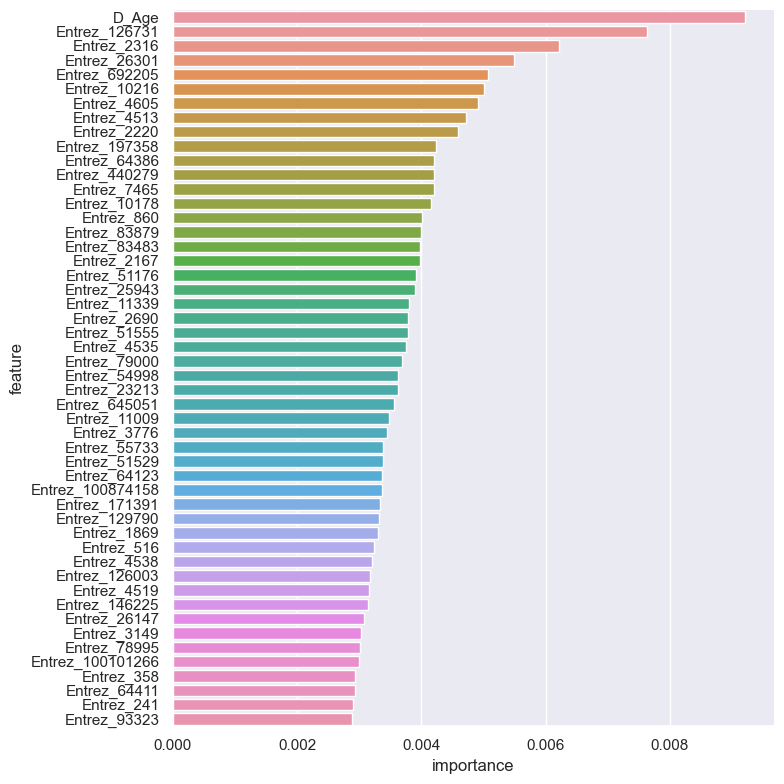

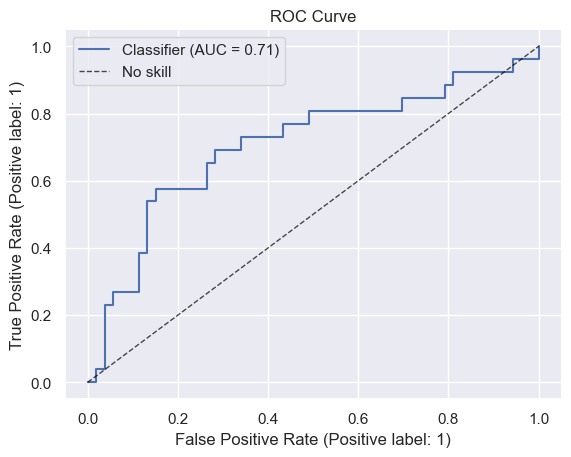

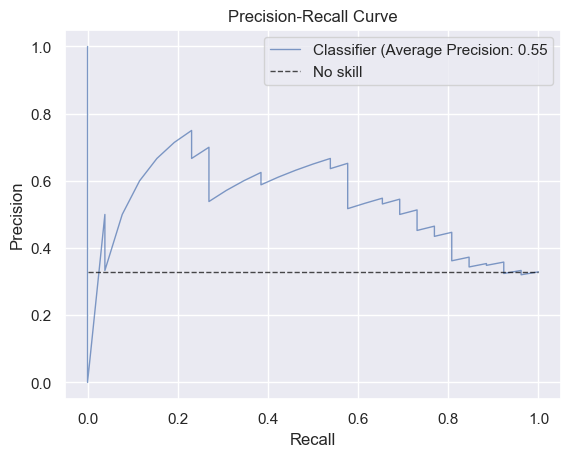

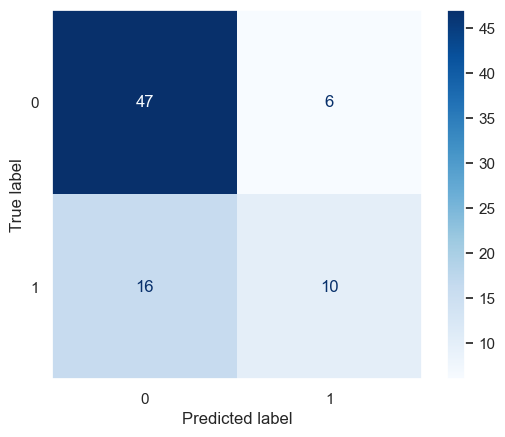

In [20]:
visual.model_evaluation_report(clf, X_test, y_test)

In [51]:
model_name = 'XGB'
clf = model.load_model(model_date, model_name)
clf

Load model from: C:\projects\side_projects\owkin_fl_data_challenge\models\model_XGB_2022-11-10.joblib


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('ohe_nominal',
                                                                               OneHotEncoder(sparse=False),
                                                                               ['D_Gender']),
                                                                              ('impute_ordinal',
                                                                               SimpleImputer(strategy='most_frequent'),
                                                                               ['D_ISS']),
                                                                              ('impute_numeric',
                                                                               SimpleImputer(strategy='median'),
                                                                               ['D_Age',
                                                                                'D_OS_FLAG',
                                                                                'D_PFS_FLAG',
                                                                                'CYTO_predicted_feature_01',
                                                                                'CYTO_predicted...
                   param_distributions={'clf__learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                                        'clf__max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'clf__n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
       270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390,
       400, 410, 420, 430, 440, 450, 460, 470, 480, 490])},
                   scoring='average_precision', verbose=1)

average_precision test data: 0.8706537506369771 

              precision    recall  f1-score   support

           0       0.94      0.92      0.93        53
           1       0.85      0.88      0.87        26

    accuracy                           0.91        79
   macro avg       0.90      0.90      0.90        79
weighted avg       0.91      0.91      0.91        79

best params: {'clf__n_estimators': 230, 'clf__max_depth': 7, 'clf__learning_rate': 0.7500000000000001}


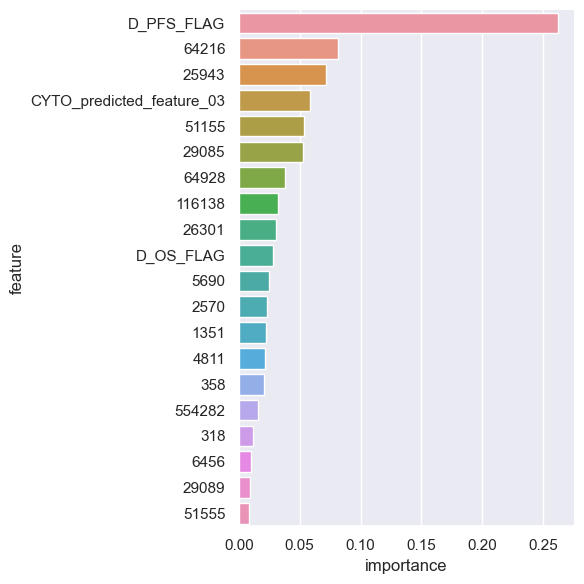

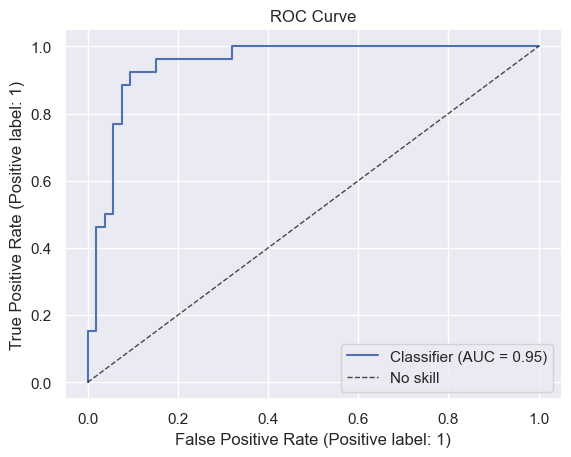

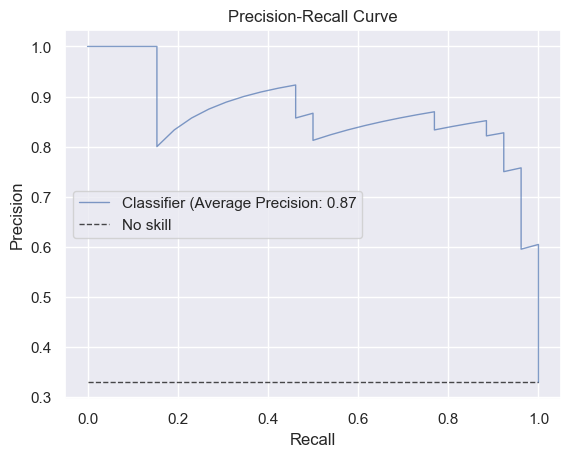

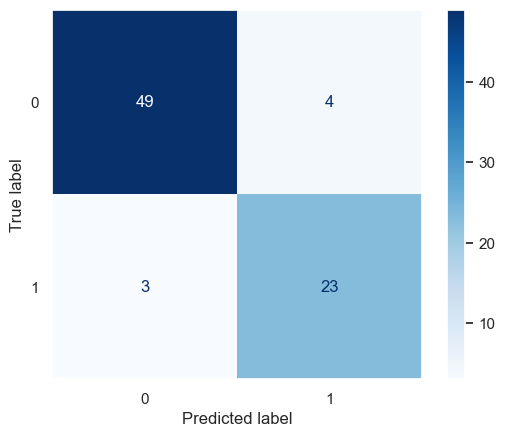

In [52]:
visual.model_evaluation_report(clf, X_test, y_test)

## Conclusion
Model performance of XGBoost in terms of ROC-AUC and PR-AUC are both better than the RandomForest pipeline. However, the dataset is quite small and the samples could potentially not representative the whole population. Hence, we cannot guarantee that the model will generalize to other datasets. For that, we need more clincal expertise about the data and problem domain.